THREE HIDDEN LAYER NEURAL NETWORK
Multi-Class Classification Assignment

Generating synthetic dataset...
- Samples: 1000
- Features: 10
- Classes: 5
Dataset generated successfully!
- Feature shape: (1000, 10)
- Label shape: (1000,)
- Class distribution: [200 200 199 202 199]

Splitting dataset into train (80%) and test (20%) sets...
Training set size: 800
Testing set size: 200

NETWORK ARCHITECTURE
Input Layer: 10 neurons
Hidden Layer 1: 64 neurons (ReLU activation)
Hidden Layer 2: 32 neurons (ReLU activation)
Hidden Layer 3: 16 neurons (ReLU activation)
Output Layer: 5 neurons (Softmax activation)
Learning Rate: 0.01

TRAINING
Epoch 0/1000 - Loss: 1.6342, Accuracy: 0.1512
Epoch 100/1000 - Loss: 1.5711, Accuracy: 0.2525
Epoch 200/1000 - Loss: 1.5469, Accuracy: 0.3787
Epoch 300/1000 - Loss: 1.5207, Accuracy: 0.4975
Epoch 400/1000 - Loss: 1.4937, Accuracy: 0.5225
Epoch 500/1000 - Loss: 1.4628, Accuracy: 0.5525
Epoch 600/1000 - Loss: 1.4267, Accuracy: 0.5687
Epoch 700/1000 - Loss: 1.3851,

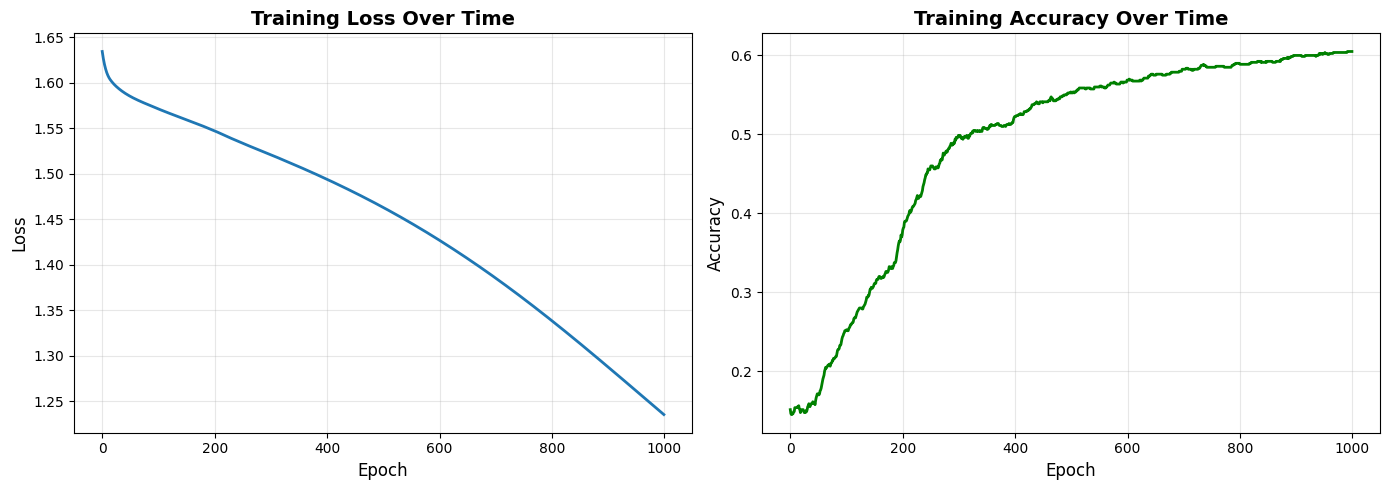

Confusion matrix plot saved as 'confusion_matrix.png'


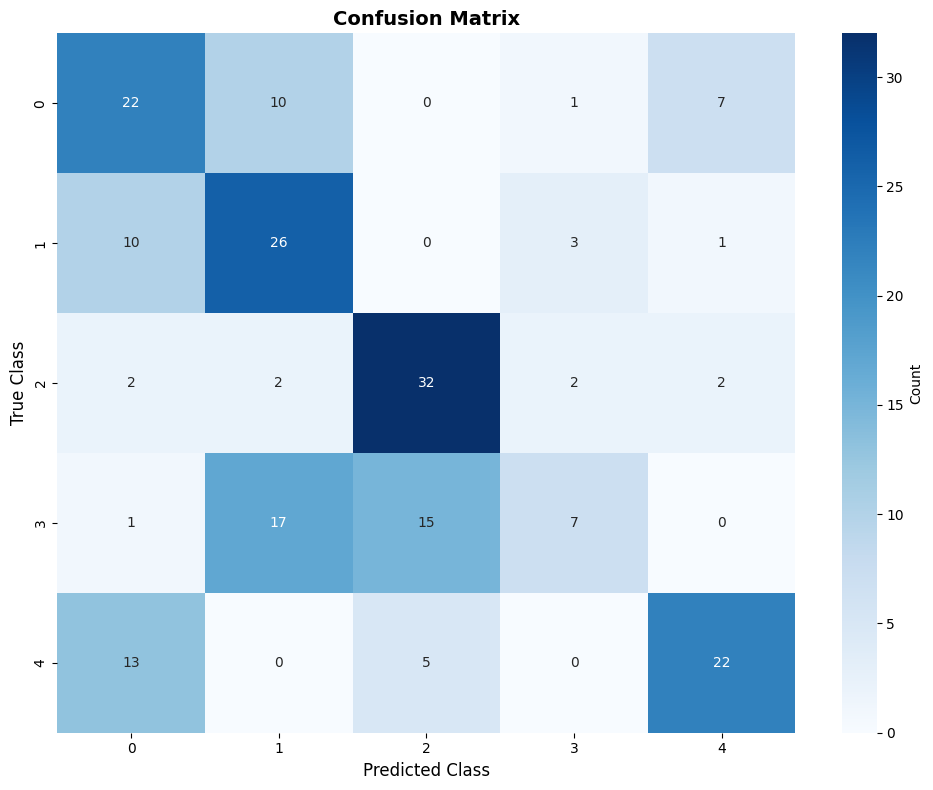

Metrics comparison plot saved as 'metrics_comparison.png'


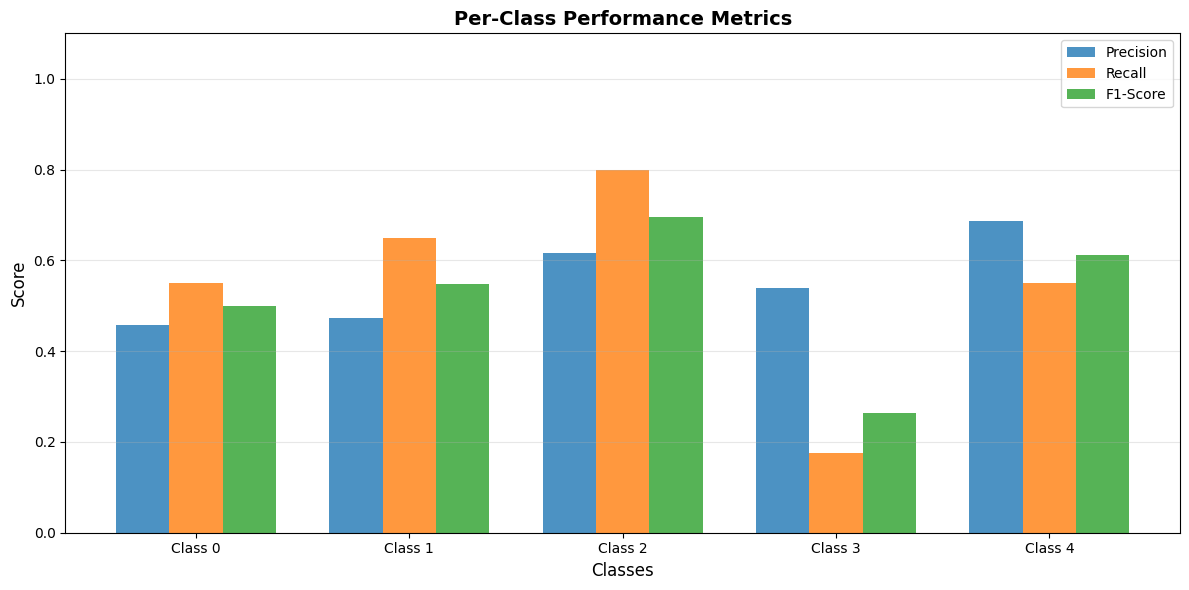


SUMMARY

Final Test Accuracy: 0.5450

Key Observations:
1. The network successfully learned to classify 5 different classes
2. Three hidden layers allow the network to learn complex decision boundaries
3. ReLU activation helps prevent vanishing gradient problem
4. Softmax output provides probability distributions for multi-class classification


In [ ]:
"""
Three Hidden Layer Neural Network for Multi-Class Classification
Assignment Implementation

"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

np.random.seed(42)


class MultiClassNeuralNetwork:
    """
    Neural Network with three hidden layers for multi-class classification.
    
    Architecture:
    - Input Layer: n_features neurons
    - Hidden Layer 1: h1_neurons neurons
    - Hidden Layer 2: h2_neurons neurons  
    - Hidden Layer 3: h3_neurons neurons
    - Output Layer: n_classes neurons (softmax activation)
    """
    
    def __init__(self, input_size, h1_size=64, h2_size=32, h3_size=16, output_size=5, learning_rate=0.01):
        """
        Initialize the neural network with random weights and biases.
        
        Parameters:
        - input_size: Number of input features
        - h1_size: Number of neurons in first hidden layer
        - h2_size: Number of neurons in second hidden layer
        - h3_size: Number of neurons in third hidden layer
        - output_size: Number of output classes
        - learning_rate: Learning rate for gradient descent
        """
        self.learning_rate = learning_rate
        
        # Initialize weights using He initialization for better convergence
        self.W1 = np.random.randn(input_size, h1_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, h1_size))
        
        self.W2 = np.random.randn(h1_size, h2_size) * np.sqrt(2.0 / h1_size)
        self.b2 = np.zeros((1, h2_size))
        
        self.W3 = np.random.randn(h2_size, h3_size) * np.sqrt(2.0 / h2_size)
        self.b3 = np.zeros((1, h3_size))
        
        self.W4 = np.random.randn(h3_size, output_size) * np.sqrt(2.0 / h3_size)
        self.b4 = np.zeros((1, output_size))
        
    def relu(self, x):
        """ReLU activation function: f(x) = max(0, x)"""
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        """Derivative of ReLU: f'(x) = 1 if x > 0, else 0"""
        return (x > 0).astype(float)
    
    def softmax(self, x):
        """
        Softmax activation function for multi-class classification.
        Converts logits to probability distribution.
        
        softmax(x_i) = exp(x_i) / sum(exp(x_j)) for all j
        """
        # Subtract max for numerical stability
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward_propagation(self, X):
        """
        Forward pass through the network.
        
        Returns all intermediate activations for use in backpropagation.
        """
        # Input to Hidden Layer 1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        
        # Hidden Layer 1 to Hidden Layer 2
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)
        
        # Hidden Layer 2 to Hidden Layer 3
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.relu(self.z3)
        
        # Hidden Layer 3 to Output Layer
        self.z4 = np.dot(self.a3, self.W4) + self.b4
        self.a4 = self.softmax(self.z4)
        
        return self.a4
    
    def compute_loss(self, y_true, y_pred):
        """
        Compute categorical cross-entropy loss.
        
        Loss = -sum(y_true * log(y_pred)) / n_samples
        """
        m = y_true.shape[0]
        # Add small epsilon to prevent log(0)
        log_likelihood = -np.log(y_pred[range(m), y_true] + 1e-8)
        loss = np.sum(log_likelihood) / m
        return loss
    
    def backward_propagation(self, X, y_true):
        """
        Backward pass to compute gradients using backpropagation.
        
        Uses chain rule to compute gradients layer by layer from output to input.
        """
        m = X.shape[0]
        
        # Convert y_true to one-hot encoding
        y_one_hot = np.zeros_like(self.a4)
        y_one_hot[range(m), y_true] = 1
        
        # Output layer gradient
        # For softmax + cross-entropy: dL/dz4 = a4 - y_true
        dz4 = self.a4 - y_one_hot
        dW4 = np.dot(self.a3.T, dz4) / m
        db4 = np.sum(dz4, axis=0, keepdims=True) / m
        
        # Hidden layer 3 gradient
        da3 = np.dot(dz4, self.W4.T)
        dz3 = da3 * self.relu_derivative(self.z3)
        dW3 = np.dot(self.a2.T, dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m
        
        # Hidden layer 2 gradient
        da2 = np.dot(dz3, self.W3.T)
        dz2 = da2 * self.relu_derivative(self.z2)
        dW2 = np.dot(self.a1.T, dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        # Hidden layer 1 gradient
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.relu_derivative(self.z1)
        dW1 = np.dot(X.T, dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        # Update weights and biases using gradient descent
        self.W4 -= self.learning_rate * dW4
        self.b4 -= self.learning_rate * db4
        
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3
        
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
    
    def train(self, X, y, epochs=1000, verbose=True):
        """
        Train the neural network using gradient descent.
        
        Parameters:
        - X: Training features
        - y: Training labels
        - epochs: Number of training iterations
        - verbose: Whether to print training progress
        
        Returns:
        - history: Dictionary containing loss and accuracy per epoch
        """
        history = {'loss': [], 'accuracy': []}
        
        for epoch in range(epochs):
            # Forward propagation
            y_pred = self.forward_propagation(X)
            
            # Compute loss
            loss = self.compute_loss(y, y_pred)
            
            # Backward propagation
            self.backward_propagation(X, y)
            
            # Compute accuracy
            predictions = np.argmax(y_pred, axis=1)
            accuracy = np.mean(predictions == y)
            
            # Store metrics
            history['loss'].append(loss)
            history['accuracy'].append(accuracy)
            
            # Print progress
            if verbose and (epoch % 100 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch}/{epochs} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return history
    
    def predict(self, X):
        """
        Make predictions on new data.
        
        Returns:
        - Class predictions (integers from 0 to n_classes-1)
        """
        y_pred = self.forward_propagation(X)
        return np.argmax(y_pred, axis=1)
    
    def predict_proba(self, X):
        """
        Get probability distributions for predictions.
        
        Returns:
        - Probability matrix of shape (n_samples, n_classes)
        """
        return self.forward_propagation(X)


def generate_synthetic_dataset(n_samples=1000, n_features=10, n_classes=5):
    """
    Generate synthetic multi-class classification dataset.
    
    Parameters:
    - n_samples: Number of samples to generate
    - n_features: Number of input features
    - n_classes: Number of output classes
    
    Returns:
    - X: Feature matrix
    - y: Label vector
    """
    print(f"\nGenerating synthetic dataset...")
    print(f"- Samples: {n_samples}")
    print(f"- Features: {n_features}")
    print(f"- Classes: {n_classes}")
    
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=8,
        n_redundant=2,
        n_classes=n_classes,
        n_clusters_per_class=1,
        random_state=42
    )
    
    # Normalize features to [0, 1] range
    X = (X - X.min()) / (X.max() - X.min())
    
    print(f"Dataset generated successfully!")
    print(f"- Feature shape: {X.shape}")
    print(f"- Label shape: {y.shape}")
    print(f"- Class distribution: {np.bincount(y)}")
    
    return X, y


def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model on test data.
    
    Returns:
    - Dictionary containing various evaluation metrics
    """
    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None, zero_division=0)
    recall = recall_score(y_test, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=None, zero_division=0)
    
    # Overall metrics (macro average)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\nOverall Accuracy: {accuracy:.4f}")
    print(f"\nMacro-averaged Metrics:")
    print(f"- Precision: {precision_macro:.4f}")
    print(f"- Recall: {recall_macro:.4f}")
    print(f"- F1-Score: {f1_macro:.4f}")
    
    print(f"\nPer-Class Metrics:")
    print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 48)
    for i in range(len(precision)):
        print(f"{i:<8} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': y_pred
    }


def plot_training_history(history):
    """Plot training loss and accuracy over epochs."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot loss
    ax1.plot(history['loss'], linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracy
    ax2.plot(history['accuracy'], linewidth=2, color='green')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training Accuracy Over Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    print("\nTraining history plot saved as 'training_history.png'")
    plt.show()


def plot_confusion_matrix(cm, n_classes=5):
    """Plot confusion matrix as a heatmap."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(n_classes),
                yticklabels=range(n_classes),
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted Class', fontsize=12)
    plt.ylabel('True Class', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("Confusion matrix plot saved as 'confusion_matrix.png'")
    plt.show()


def plot_metrics_comparison(metrics):
    """Plot per-class metrics comparison."""
    n_classes = len(metrics['precision'])
    classes = [f'Class {i}' for i in range(n_classes)]
    
    x = np.arange(n_classes)
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, metrics['precision'], width, label='Precision', alpha=0.8)
    ax.bar(x, metrics['recall'], width, label='Recall', alpha=0.8)
    ax.bar(x + width, metrics['f1_score'], width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Classes', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    print("Metrics comparison plot saved as 'metrics_comparison.png'")
    plt.show()


def main():
    """
    Main function to execute the complete assignment workflow.
    """
    print("="*60)
    print("THREE HIDDEN LAYER NEURAL NETWORK")
    print("Multi-Class Classification Assignment")
    print("="*60)
    
    # Step 1: Generate synthetic dataset
    X, y = generate_synthetic_dataset(n_samples=1000, n_features=10, n_classes=5)
    
    # Step 2: Split dataset into training and testing sets
    print("\nSplitting dataset into train (80%) and test (20%) sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Testing set size: {X_test.shape[0]}")
    
    # Step 3: Initialize neural network
    print("\n" + "="*60)
    print("NETWORK ARCHITECTURE")
    print("="*60)
    print("Input Layer: 10 neurons")
    print("Hidden Layer 1: 64 neurons (ReLU activation)")
    print("Hidden Layer 2: 32 neurons (ReLU activation)")
    print("Hidden Layer 3: 16 neurons (ReLU activation)")
    print("Output Layer: 5 neurons (Softmax activation)")
    print("Learning Rate: 0.01")
    
    model = MultiClassNeuralNetwork(
        input_size=10,
        h1_size=64,
        h2_size=32,
        h3_size=16,
        output_size=5,
        learning_rate=0.01
    )
    
    # Step 4: Train the model
    print("\n" + "="*60)
    print("TRAINING")
    print("="*60)
    
    history = model.train(X_train, y_train, epochs=1000, verbose=True)
    
    # Step 5: Evaluate the model
    metrics = evaluate_model(model, X_test, y_test)
    
    # Step 6: Visualize results
    print("\n" + "="*60)
    print("VISUALIZATION")
    print("="*60)
    
    plot_training_history(history)
    plot_confusion_matrix(metrics['confusion_matrix'])
    plot_metrics_comparison(metrics)
    
    # Step 7: Final summary
    print("\n" + "="*60)
    print("SUMMARY")
    print("="*60)
    print(f"\nFinal Test Accuracy: {metrics['accuracy']:.4f}")
    print("\nKey Observations:")
    print("1. The network successfully learned to classify 5 different classes")
    print("2. Three hidden layers allow the network to learn complex decision boundaries")
    print("3. ReLU activation helps prevent vanishing gradient problem")
    print("4. Softmax output provides probability distributions for multi-class classification")
    


if __name__ == "__main__":
    main()